In [27]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer, PowerTransformer # var transformer
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

In [28]:
# load the data
df_train = pd.read_csv('C:\\Users\\sabri\\Desktop\\doctorat\\kaggle\\Houses Prices\\train_house.csv')
df_test = pd.read_csv('C:\\Users\\sabri\\Desktop\\doctorat\\kaggle\\Houses Prices\\test_house.csv')
df = df_train.append(df_test , ignore_index = True)

# basic inspection
df_train.shape, df_test.shape, df.shape

((1460, 81), (1459, 80), (2919, 81))

In [29]:
SalePrice = df_train.SalePrice

# Data Preprocessing

In [30]:
# divide the data into numerical ("quan") and categorical ("qual") features
quan = list( df_train.loc[:,df_train.dtypes != 'object'].drop('Id',axis=1).columns.values )
qual = list( df_train.loc[:,df_train.dtypes == 'object'].columns.values )
len(quan), len(qual)

(37, 43)

In [31]:
quan.remove('SalePrice')

### Impute numerical data

In [38]:
# print the variables that contain missing data
miss_quan = [var for var in quan if df_train[var].isnull().sum() > 0]
miss_qual = [var for var in qual if df_train[var].isnull().sum() > 0]
print("Number of missing vlue in training : {}".format(len(miss_quan)))
print("Number of missing vlue in test : {}".format(len(miss_qual)))

Number of missing vlue in training : 3
Number of missing vlue in test : 16


In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

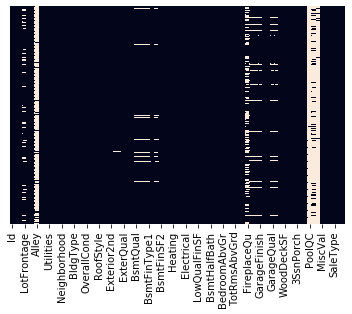

In [40]:
#The variables have a missing value
sns.heatmap(df_train.isnull(), yticklabels = False, cbar = False)

In [42]:
# find the percentage of missing data within those variables
df_train[miss_quan].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

In [43]:
df_train[miss_qual].isnull().mean()

Alley           0.937671
MasVnrType      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [8]:
for variable in miss_quan:
    df_train[variable].fillna(df[variable].median(), inplace=True)
    df_test[variable].fillna(df[variable].median(), inplace=True)

In [9]:
df_test[miss_quan].isnull().mean()

LotFrontage     0.0
MasVnrArea      0.0
BsmtFinSF1      0.0
BsmtFinSF2      0.0
BsmtUnfSF       0.0
TotalBsmtSF     0.0
BsmtFullBath    0.0
BsmtHalfBath    0.0
GarageYrBlt     0.0
GarageCars      0.0
GarageArea      0.0
dtype: float64

In [10]:
#median = df_train['LotFrontage'].median()
#df_train.LotFrontage.fillna(median, inplace=True)
#df_test.LotFrontage.fillna(median, inplace=True)

#median = df_train['MasVnrArea'].median()
#df_train.MasVnrArea.fillna(median, inplace=True)
#df_test.MasVnrArea.fillna(median, inplace=True)

#median = df_train['GarageYrBlt'].median()
#df_train.GarageYrBlt.fillna(median, inplace=True)
#df_test.MasVnrArea.fillna(median, inplace=True)

### Impute caterigocal data

In [11]:
# print the variables that contain missing data
cat_miss = [var for var in qual if df[var].isnull().sum() > 0]
len(cat_miss)

23

In [12]:
# find the percentage of missing data within those variables
df[cat_miss].isnull().mean()

MSZoning        0.001370
Alley           0.932169
Utilities       0.000685
Exterior1st     0.000343
Exterior2nd     0.000343
MasVnrType      0.008222
BsmtQual        0.027749
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtFinType1    0.027064
BsmtFinType2    0.027407
Electrical      0.000343
KitchenQual     0.000343
Functional      0.000685
FireplaceQu     0.486468
GarageType      0.053786
GarageFinish    0.054471
GarageQual      0.054471
GarageCond      0.054471
PoolQC          0.996574
Fence           0.804385
MiscFeature     0.964029
SaleType        0.000343
dtype: float64

In [13]:
for var in cat_miss:
    df_train[var].fillna('Missing', inplace=True)
    df_test[var].fillna('Missing', inplace=True)

### Categorical-Encoding

In [14]:
def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}


def integer_encode(train, test, variable, ordinal_mapping):
    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [15]:
for variable in qual:
    mappings = find_category_mappings(df_train, variable)
    integer_encode(df_train, df_test, variable, mappings)

In [16]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

### Variable Transformation

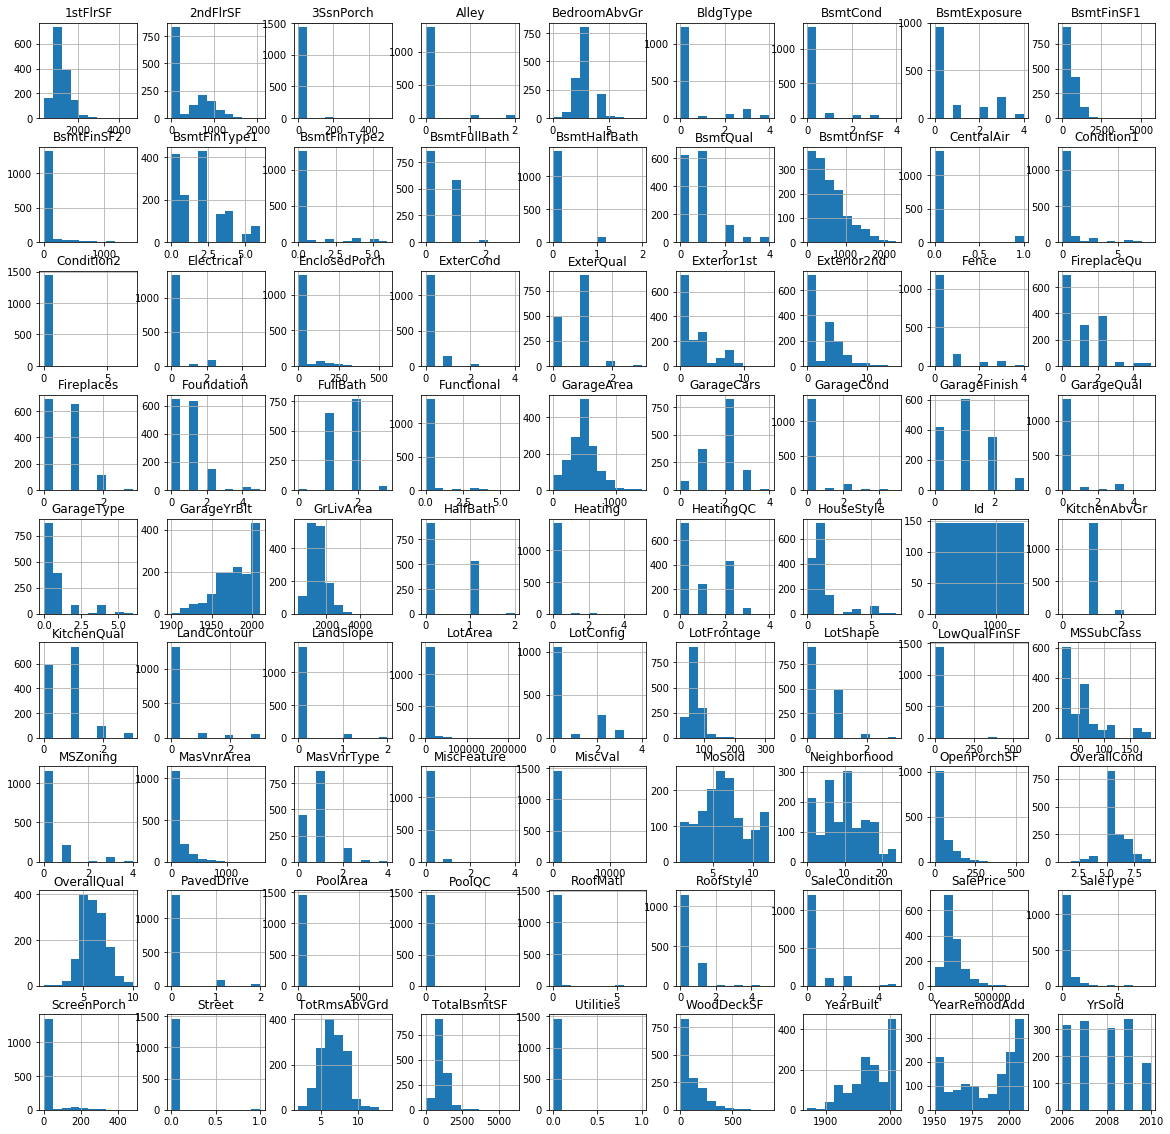

In [18]:
# let's explore the distribution of the numerical variables

df_train.hist(figsize=(20,20))
plt.show()

In [19]:
from scipy.stats import skew

# print the skewness of each numerical feature
for i in df_train.columns:
    print(i+': {}'.format(round(skew(df_train[i]),2)))

Id: 0.0
MSSubClass: 1.41
MSZoning: 2.79
LotFrontage: 2.43
LotArea: 12.2
Street: 15.5
Alley: 4.28
LotShape: 1.31
LandContour: 3.47
Utilities: 38.17
LotConfig: 1.31
LandSlope: 4.81
Neighborhood: 0.19
Condition1: 3.77
Condition2: 12.71
BldgType: 2.21
HouseStyle: 2.06
OverallQual: 0.22
OverallCond: 0.69
YearBuilt: -0.61
YearRemodAdd: -0.5
RoofStyle: 3.53
RoofMatl: 9.01
Exterior1st: 1.24
Exterior2nd: 1.07
MasVnrType: 0.87
MasVnrArea: 2.67
ExterQual: 0.4
ExterCond: 3.68
Foundation: 1.68
BsmtQual: 1.5
BsmtCond: 3.55
BsmtExposure: 1.18
BsmtFinType1: 0.78
BsmtFinSF1: 1.68
BsmtFinType2: 2.77
BsmtFinSF2: 4.25
BsmtUnfSF: 0.92
TotalBsmtSF: 1.52
Heating: 10.01
HeatingQC: 0.54
CentralAir: 3.53
Electrical: 3.53
1stFlrSF: 1.38
2ndFlrSF: 0.81
LowQualFinSF: 9.0
GrLivArea: 1.37
BsmtFullBath: 0.6
BsmtHalfBath: 4.1
FullBath: 0.04
HalfBath: 0.68
BedroomAbvGr: 0.21
KitchenAbvGr: 4.48
KitchenQual: 0.91
TotRmsAbvGrd: 0.68
Functional: 4.58
Fireplaces: 0.65
FireplaceQu: 1.17
GarageType: 2.14
GarageYrBlt: -0.67
Ga

In [20]:
#select the numerical var
cols = []

for col in df_train.columns:

    if df_train[col].dtypes != 'O' and col != 'Id':  # if the variable is numerical
        
        if np.sum(np.where(df_train[col] <= 0, 1, 0)) == 0:  # if the variable is positive
        
            cols.append(col)  # append variable to the list

cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 '1stFlrSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'MoSold',
 'YrSold',
 'SalePrice']

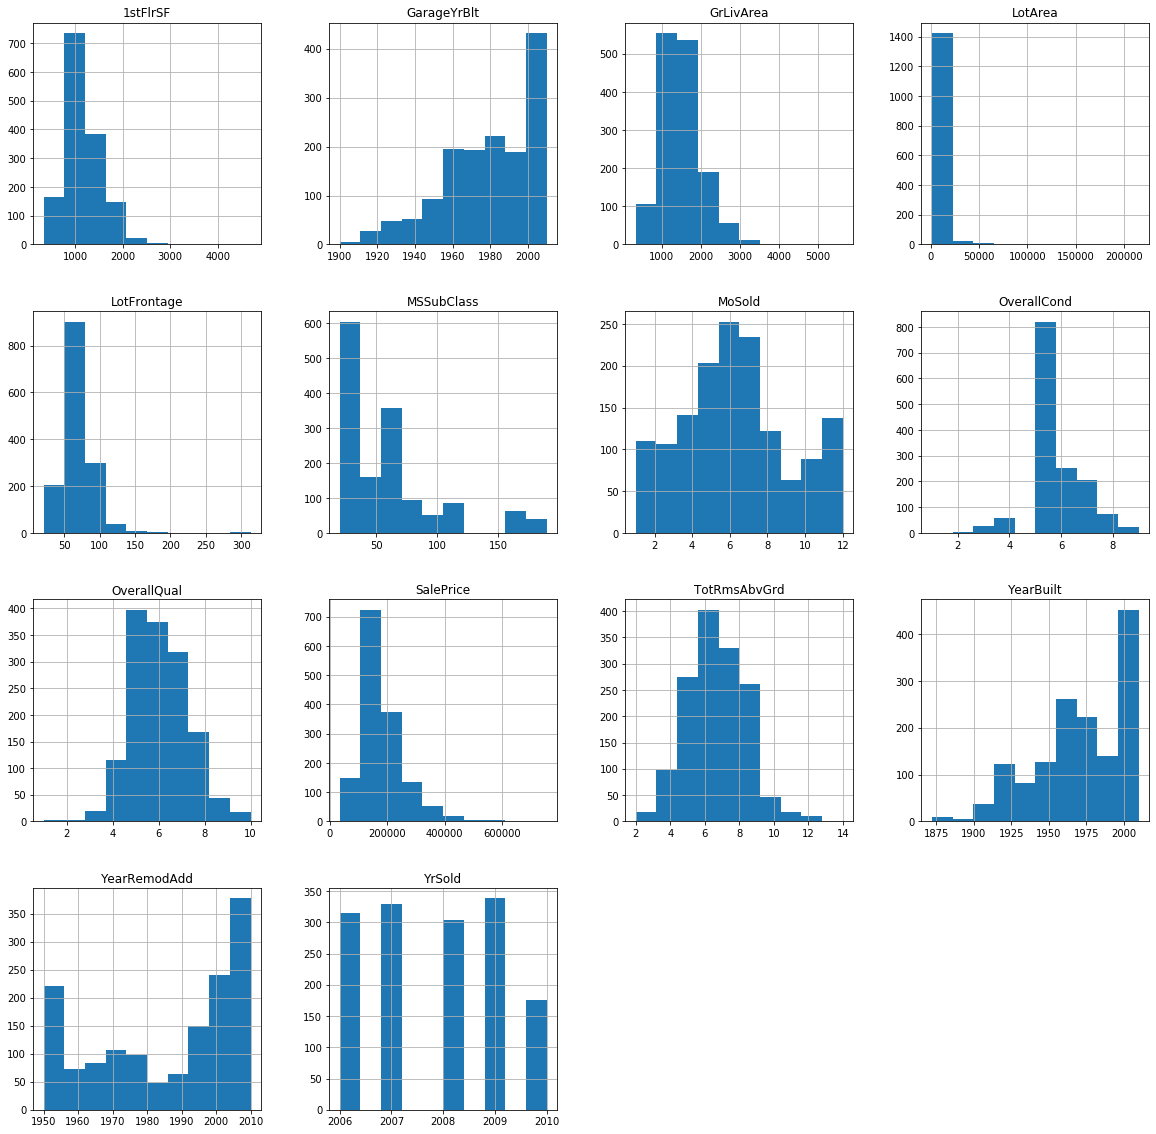

In [ ]:
# let's explore the distribution of the numerical variables

df_train[cols].hist(figsize=(20,20))
plt.show()

In [ ]:
# plot the histograms to have a quick look at the variable distribution
# histogram and Q-Q plots

def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

In [ ]:
# create a log transformer
transformer = FunctionTransformer(np.log, validate=True)
# transform all the numerical and positive variables from training
data_t = transformer.transform(df_train[cols].fillna(1))

data_t = pd.DataFrame(data_t, columns = cols)

In [ ]:
df_train['LotFrontage']

In [ ]:
data_t['LotFrontage']

In [ ]:
for var in cols:
    df_train[var] = data_t[var]

In [ ]:
df_train

In [ ]:
diagnostic_plots(df_train, 'MSSubClass')

In [ ]:
diagnostic_plots(df_train, 'GrLivArea')

In [ ]:
# visualize the distribution of each numerical feature
quan.remove('SalePrice')
drop_sale = df_train.drop('SalePrice',axis=1)
temp = pd.melt(drop_sale, value_vars=quan)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

In [ ]:
df_train['MSSubClass']

In [ ]:
df_train[quan]

In [ ]:
df_train

### Discretisation

In [17]:
# let's visualise the values of the discrete variables
discrete = []
for var in df_train.columns:
    if len(df_train[var].unique())<20:
        #print(var, ' values: ', df_train[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

There are 57 discrete variables


In [18]:
continuous = []
for var in df_train.columns:
    if not var in discrete and var not in ['Id', 'SalePrice']:
        continuous.append(var)

In [19]:
len(continuous)

22

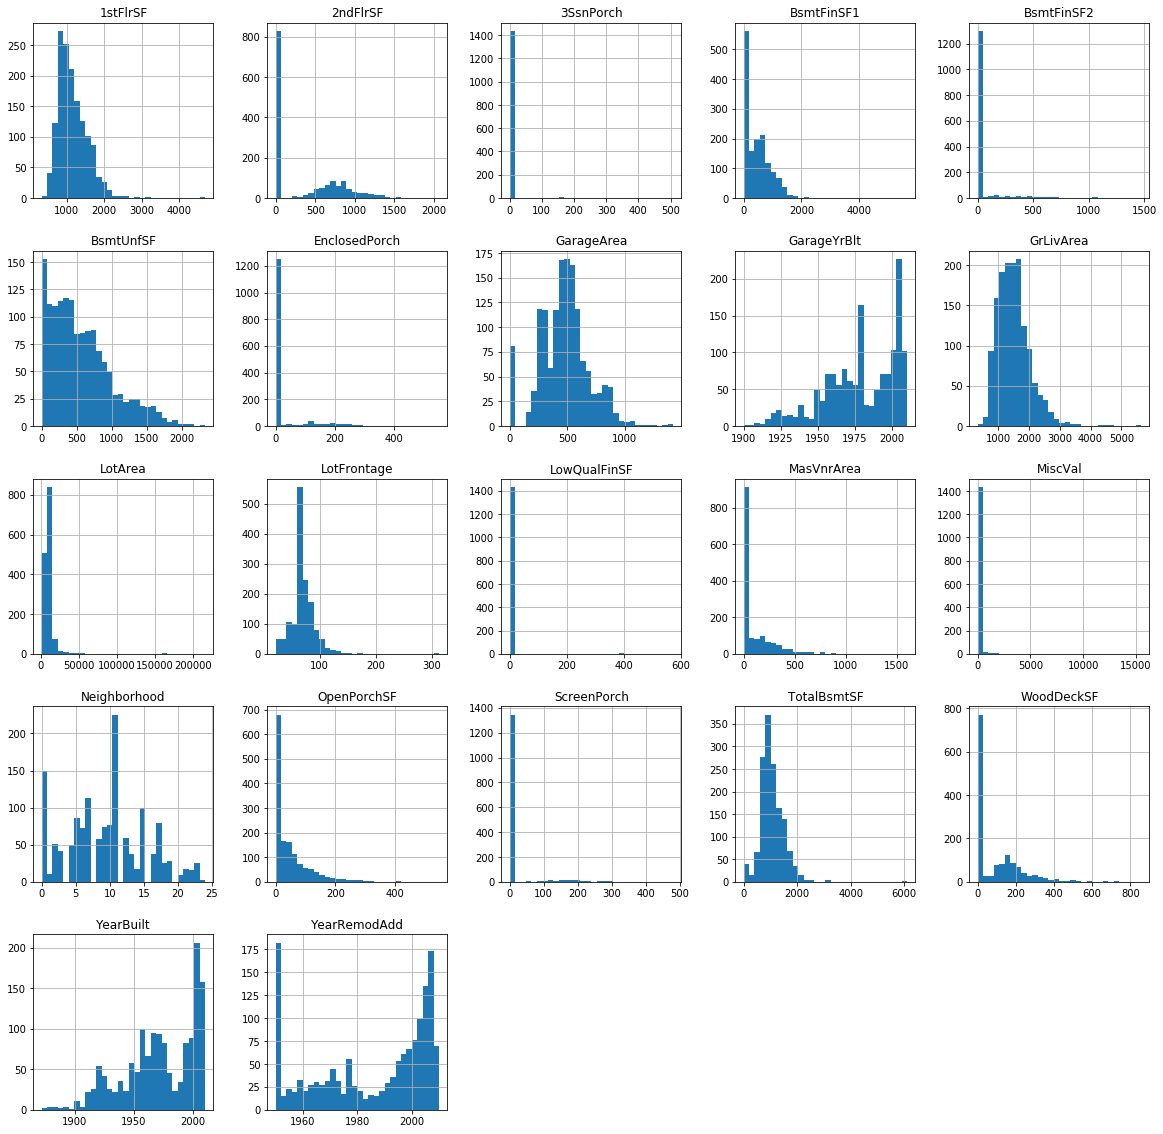

In [20]:
# let's explore the distribution of age

df_train[continuous].hist(bins=30, figsize=(20,20))
plt.show()

#### Discretisation with kmeans

In [21]:
from sklearn.preprocessing import KBinsDiscretizer
disc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
disc.fit(df_train[continuous])

KBinsDiscretizer(encode='ordinal', n_bins=5, strategy='uniform')

In [22]:
disc.bin_edges_

array([array([ 21. ,  79.4, 137.8, 196.2, 254.6, 313. ]),
       array([  1300.,  44089.,  86878., 129667., 172456., 215245.]),
       array([ 0. ,  4.8,  9.6, 14.4, 19.2, 24. ]),
       array([1872. , 1899.6, 1927.2, 1954.8, 1982.4, 2010. ]),
       array([1950., 1962., 1974., 1986., 1998., 2010.]),
       array([   0.,  320.,  640.,  960., 1280., 1600.]),
       array([   0. , 1128.8, 2257.6, 3386.4, 4515.2, 5644. ]),
       array([   0. ,  294.8,  589.6,  884.4, 1179.2, 1474. ]),
       array([   0. ,  467.2,  934.4, 1401.6, 1868.8, 2336. ]),
       array([   0., 1222., 2444., 3666., 4888., 6110.]),
       array([ 334. , 1205.6, 2077.2, 2948.8, 3820.4, 4692. ]),
       array([   0.,  413.,  826., 1239., 1652., 2065.]),
       array([  0. , 114.4, 228.8, 343.2, 457.6, 572. ]),
       array([ 334. , 1395.6, 2457.2, 3518.8, 4580.4, 5642. ]),
       array([1900., 1922., 1944., 1966., 1988., 2010.]),
       array([   0. ,  283.6,  567.2,  850.8, 1134.4, 1418. ]),
       array([  0. , 171

In [23]:
train_t = disc.transform(df_train[continuous]) 

In [24]:
test_t = disc.transform(df_test[continuous])

In [25]:
train_t = pd.DataFrame(train_t, columns = [continuous])
test_t = pd.DataFrame(test_t, columns = [continuous])

In [26]:
train_t.head()

,LotFrontage,LotArea,Neighborhood,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,4.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
4,1.0,0.0,0.0,4.0,4.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
enc = OrdinalCategoricalEncoder(encoding_method = 'ordered')

enc.fit(train_t, SalePrice)

train_t = enc.transform(train_t)
test_t = enc.transform(test_t)

ValueError: Encoder could not be fitted. Check that correct parameters and dataframe were passed during training

In [42]:
df_train['LotFrontage'].head()

0    65.0
1    80.0
2    68.0
3    60.0
4    84.0
Name: LotFrontage, dtype: float64

In [47]:
train_t 

,LotFrontage,LotArea,Neighborhood,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,4.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
4,1.0,0.0,0.0,4.0,4.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,3.0,4.0,4.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,1.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
1457,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,0.0,0.0,2.0,2.0,3.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0


### Outlier Engineering

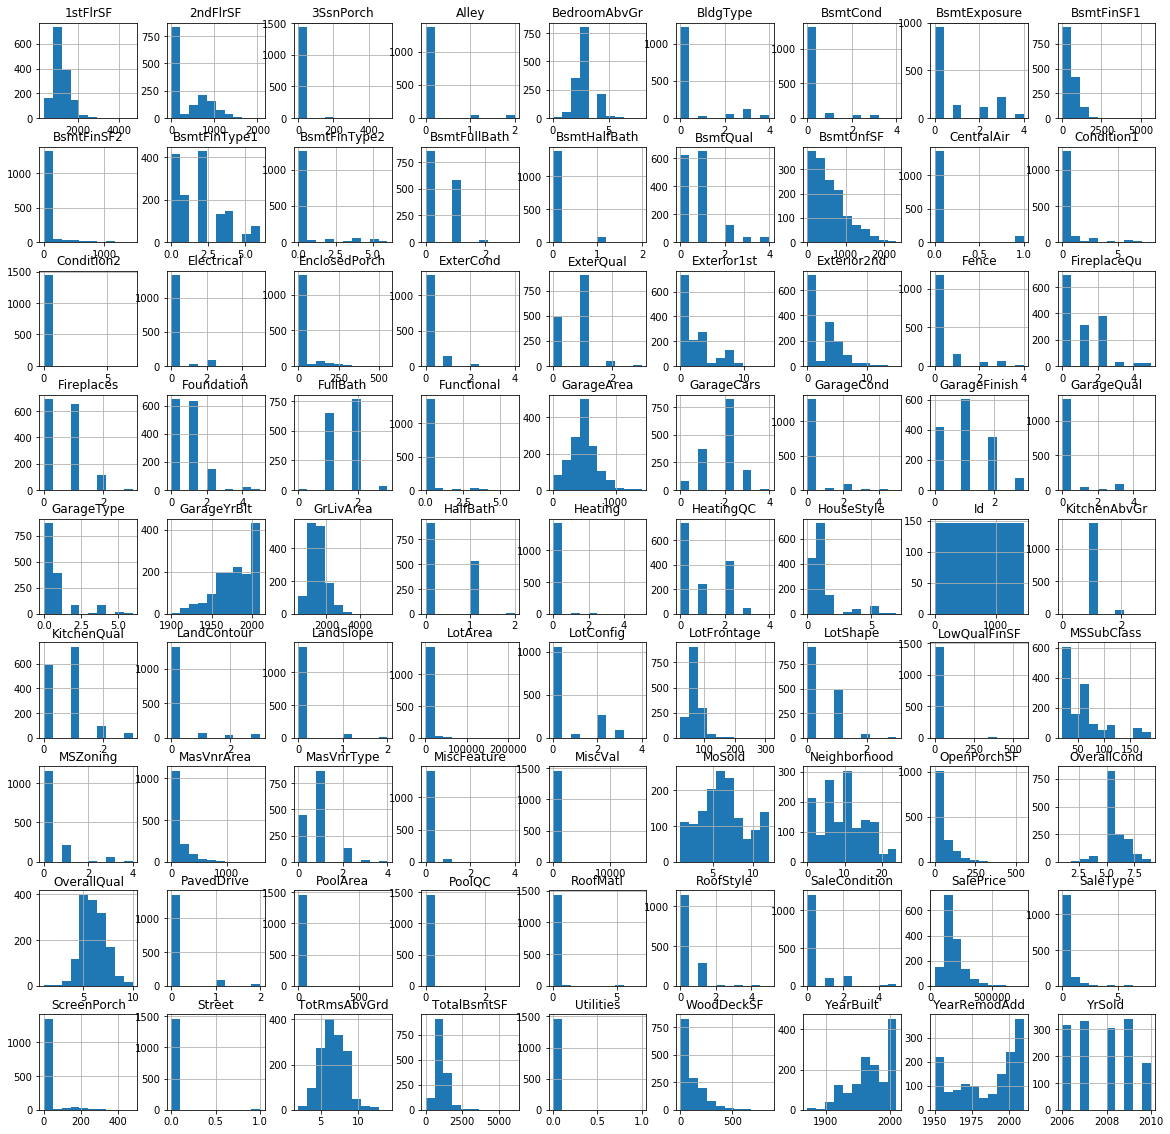

In [17]:
# let's explore the distribution of the numerical variables

df_train.hist(figsize=(20,20))
plt.show()

In [18]:
# function to create histogram, Q-Q plot and boxplot.


def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('var quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

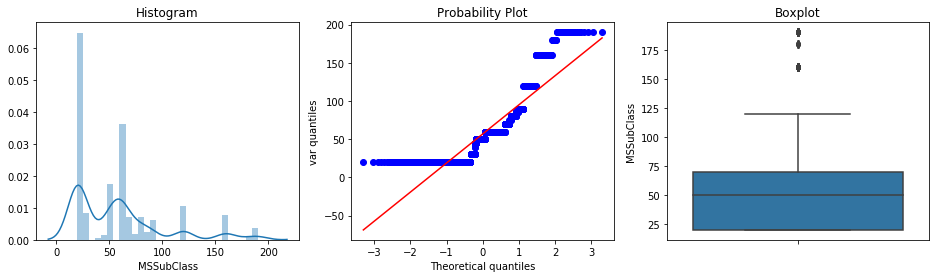

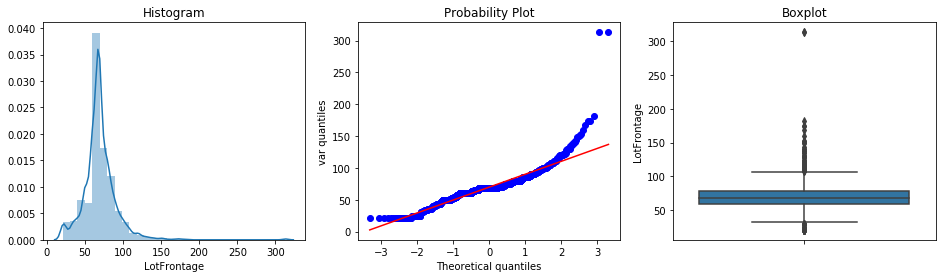

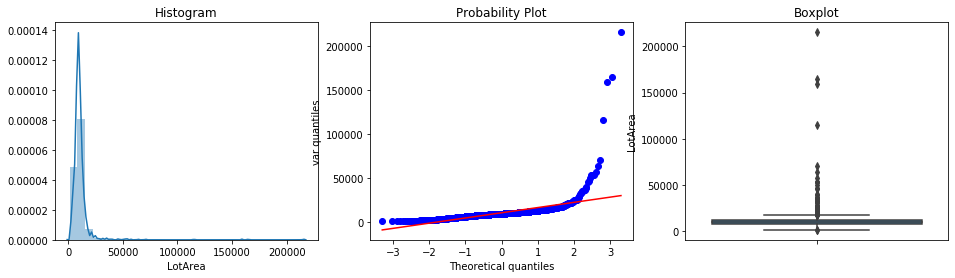

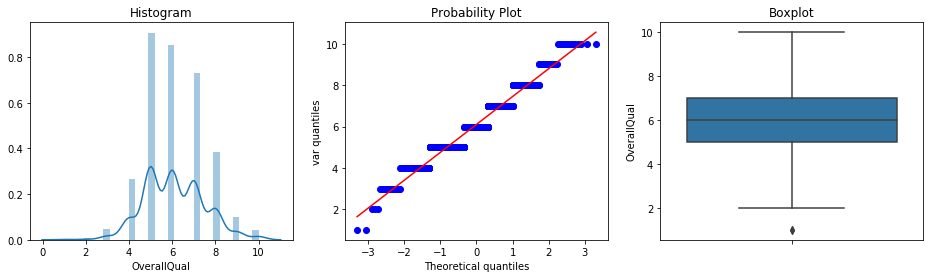

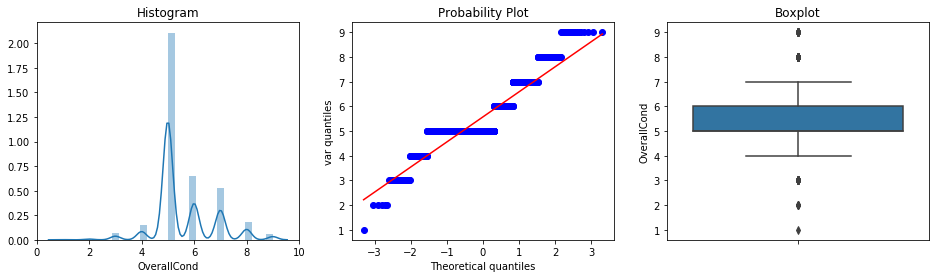

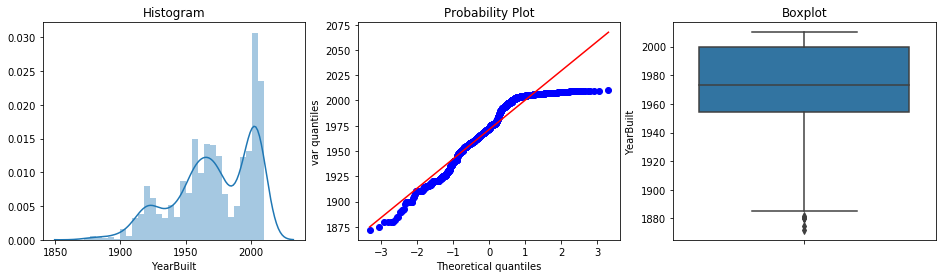

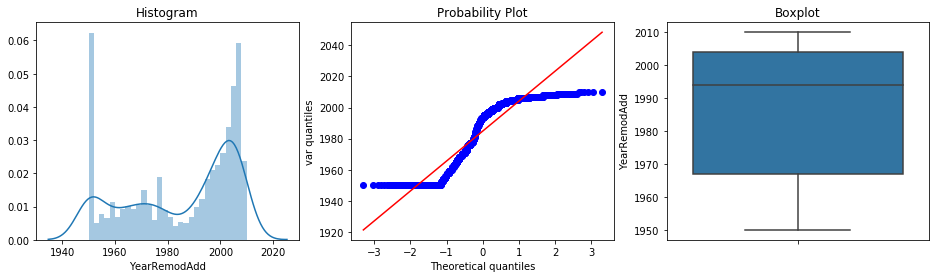

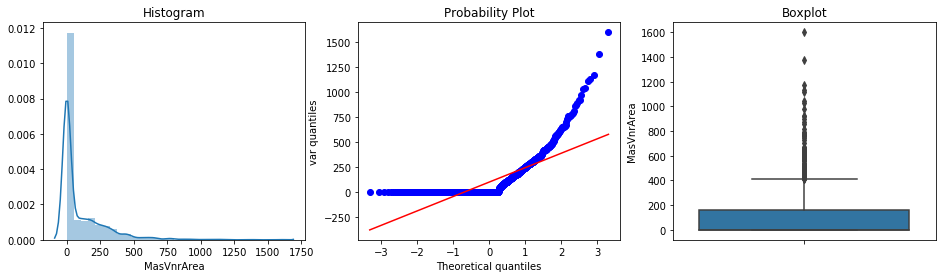

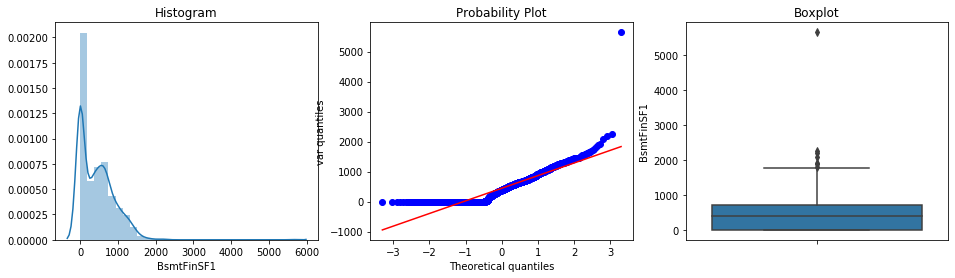

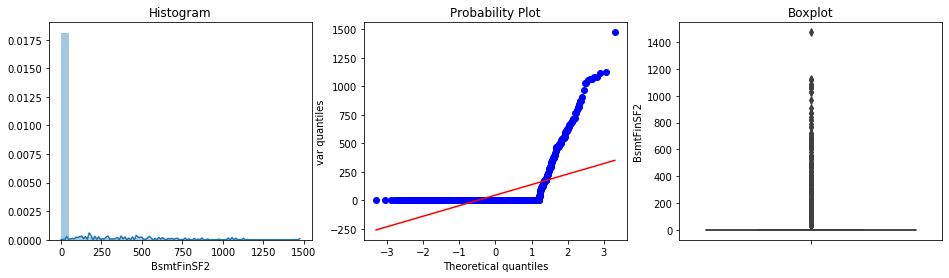

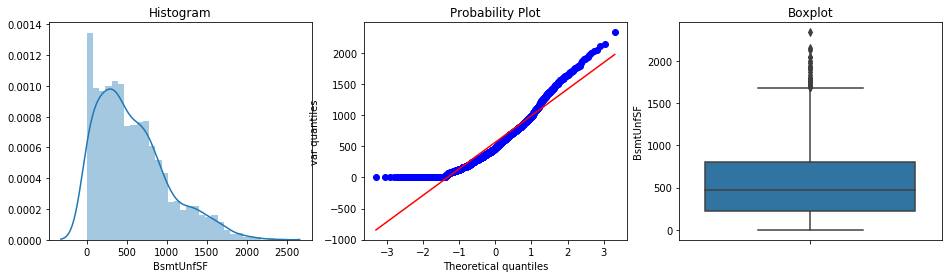

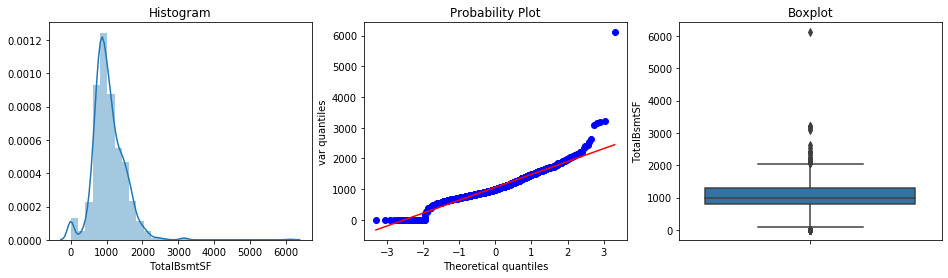

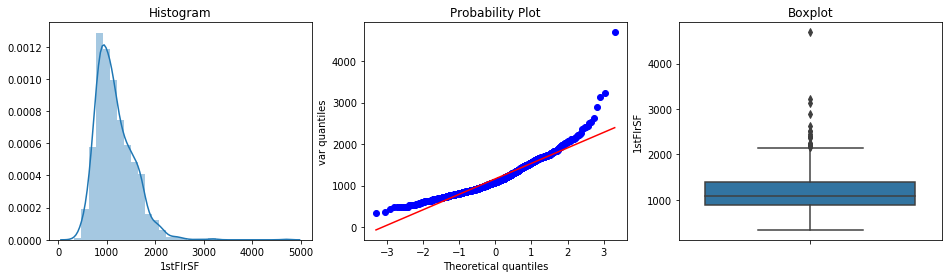

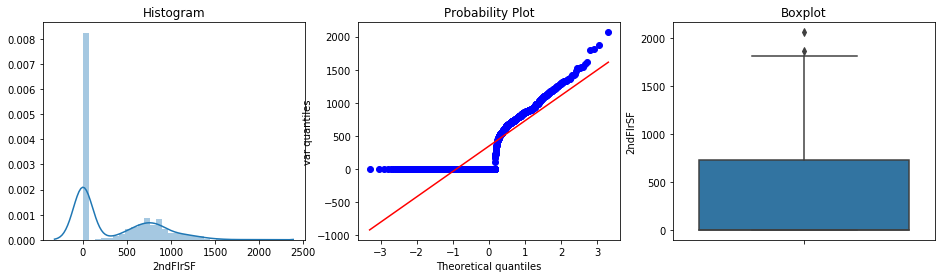

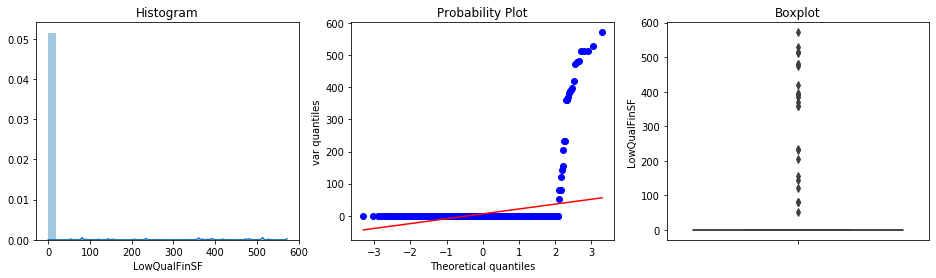

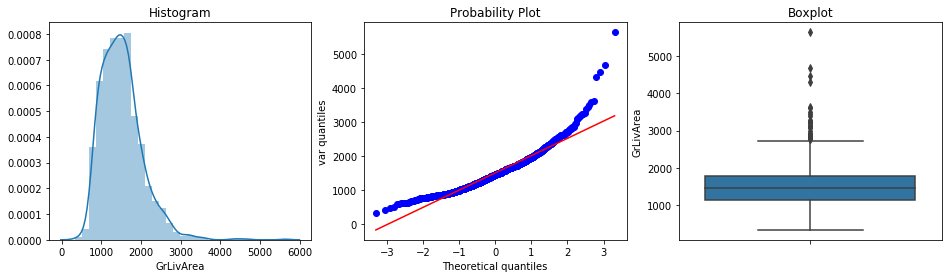

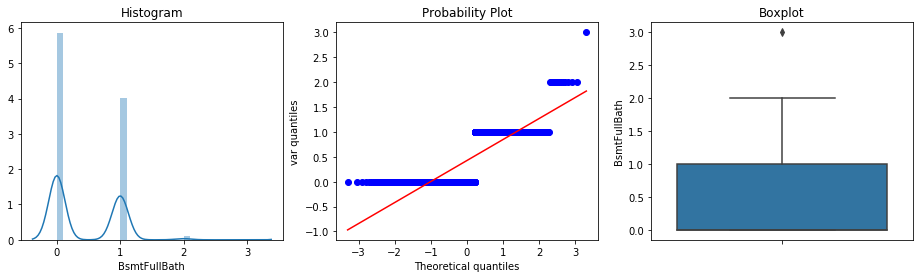

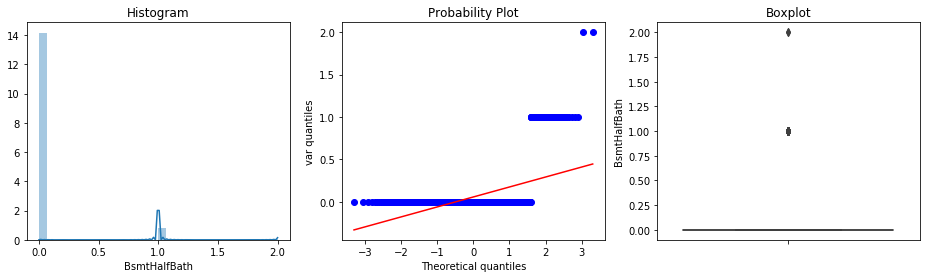

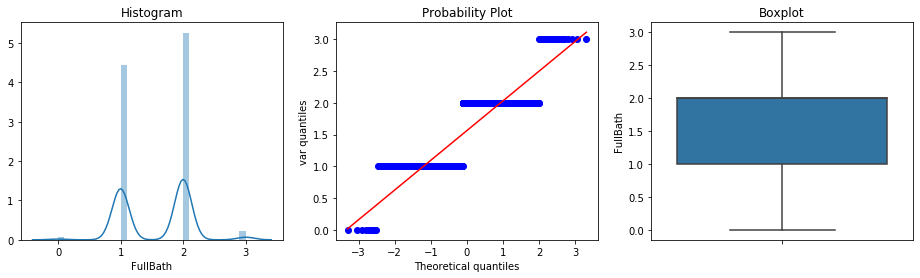

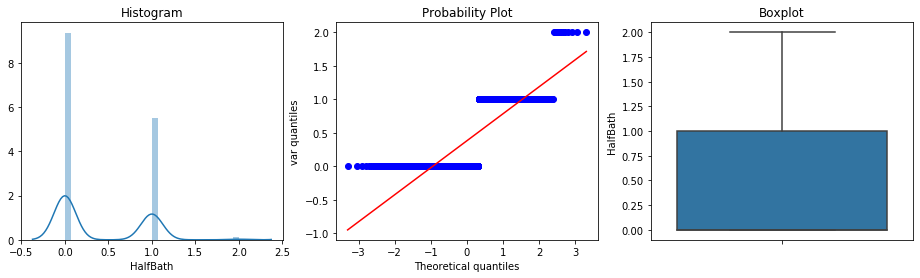

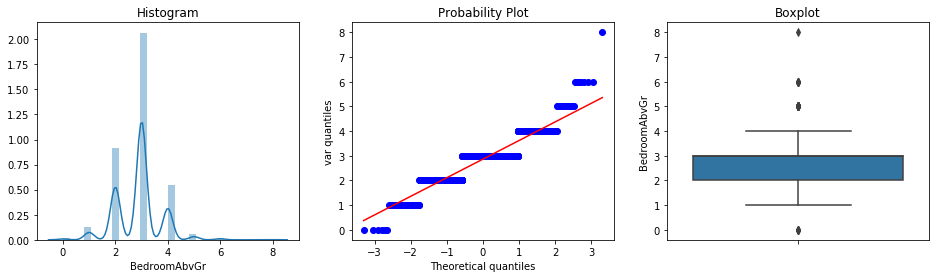

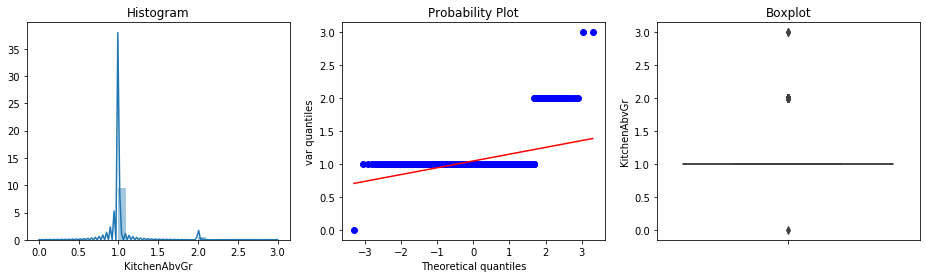

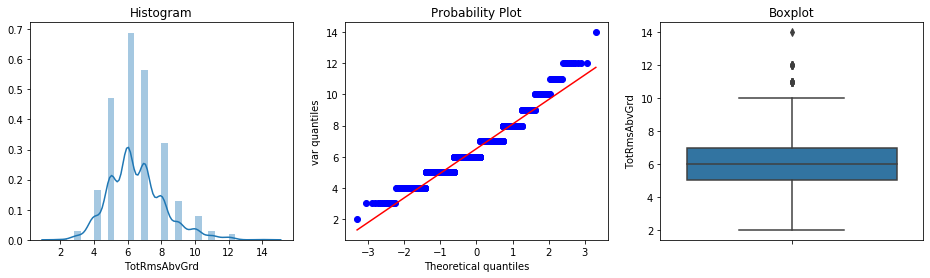

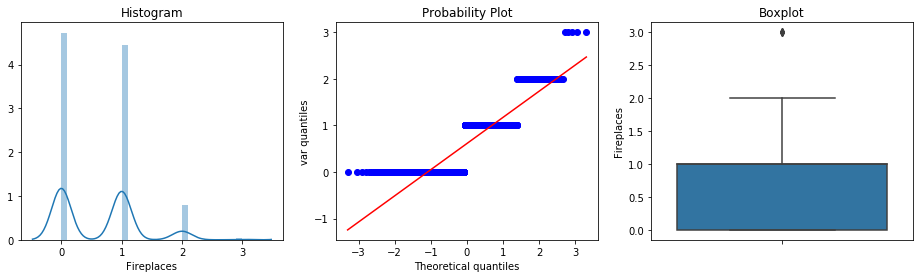

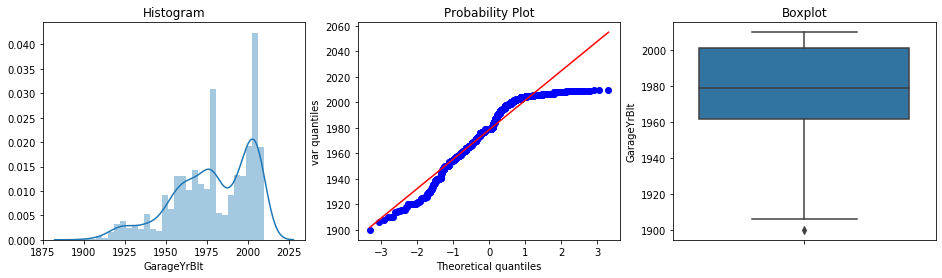

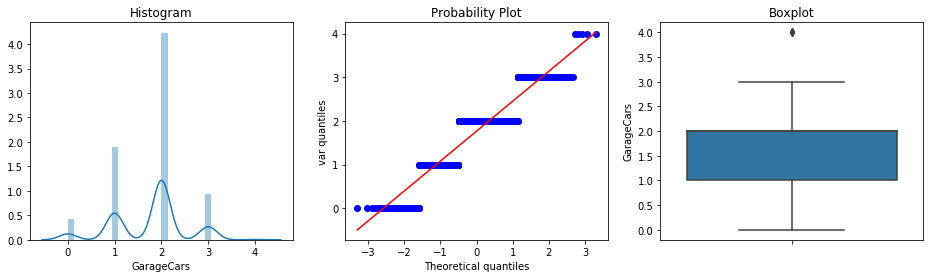

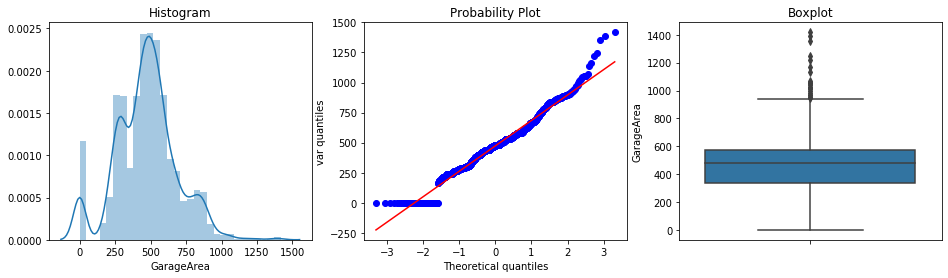

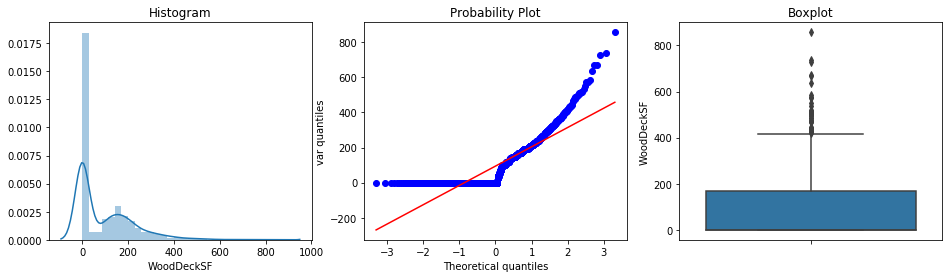

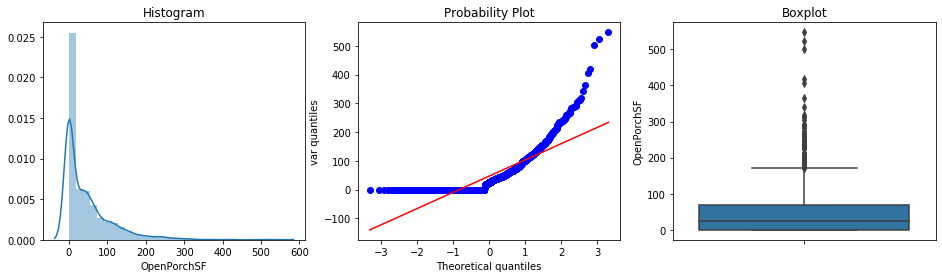

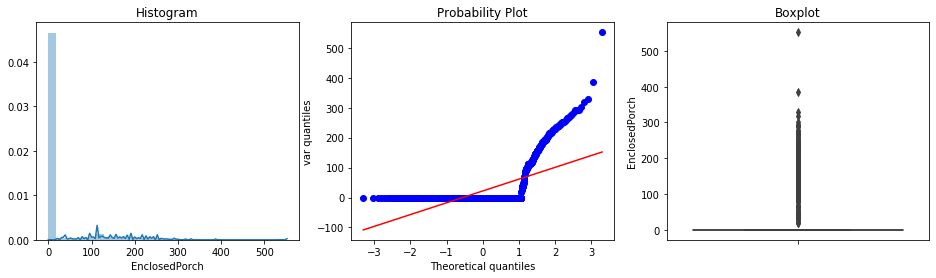

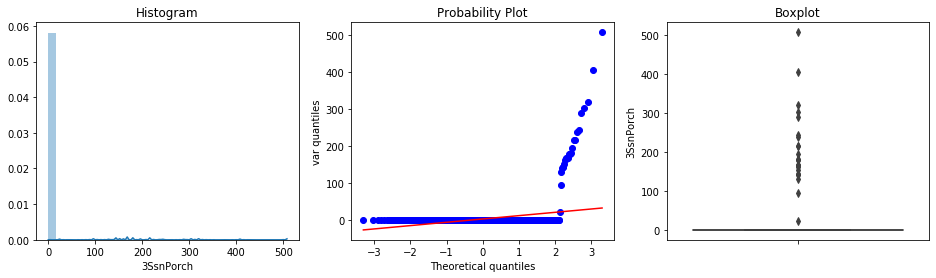

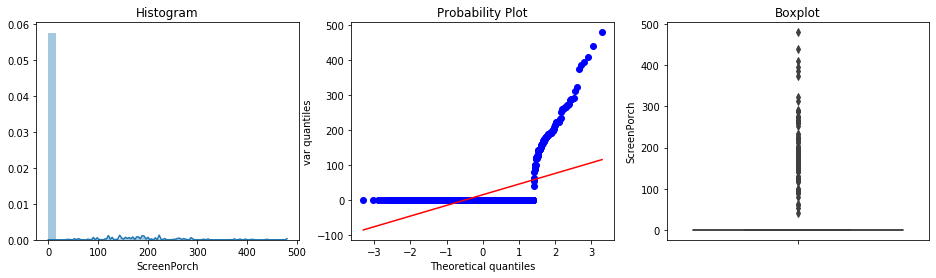

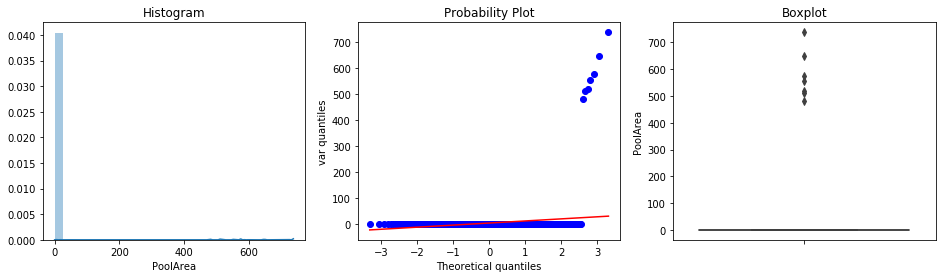

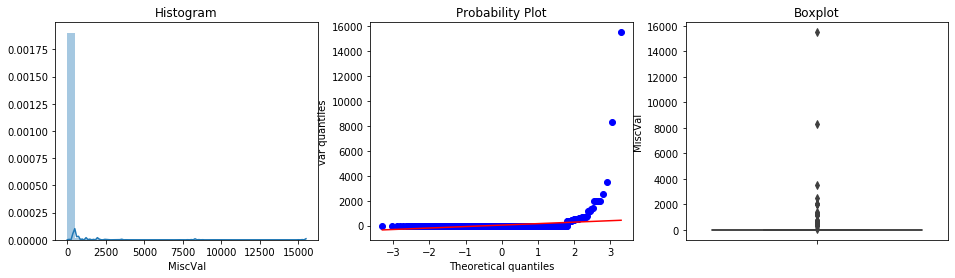

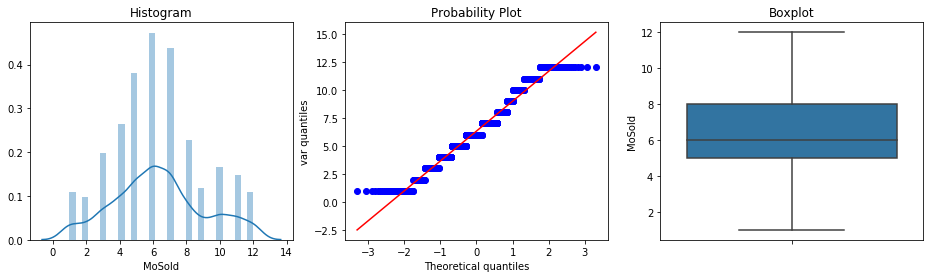

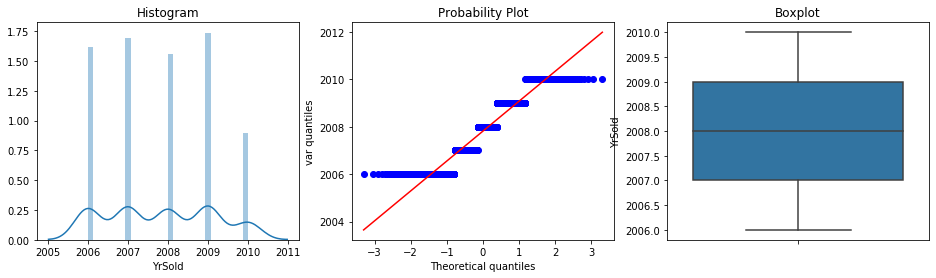

In [19]:
for var in quan:
    diagnostic_plots(df_train, var)

In [21]:
quan

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [22]:
def find_boundaries(df, variable):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(0.05)
    upper_boundary = df[variable].quantile(0.95)

    return upper_boundary, lower_boundary

In [23]:
# find limits of all variables
outliers = {}
for var in quan:
    outliers[var] = find_boundaries(df_train, var)

In [29]:
outliers['MSSubClass'][0]

160.0

In [25]:
# Now let's replace the outliers by the maximum and minimum limit
for var in quan:
    df_train[var] = np.where(df_train[var] > outliers[var][0], outliers[var][0],
                       np.where(df_train[var] < outliers[var][1], outliers[var][1], df_train[var]))

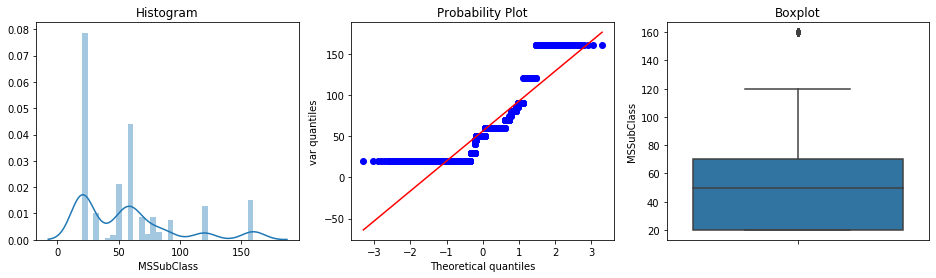

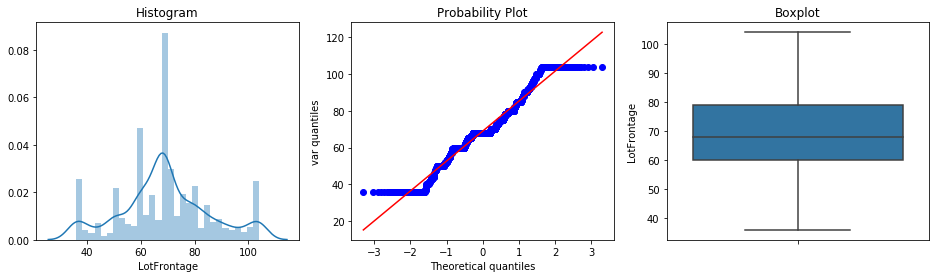

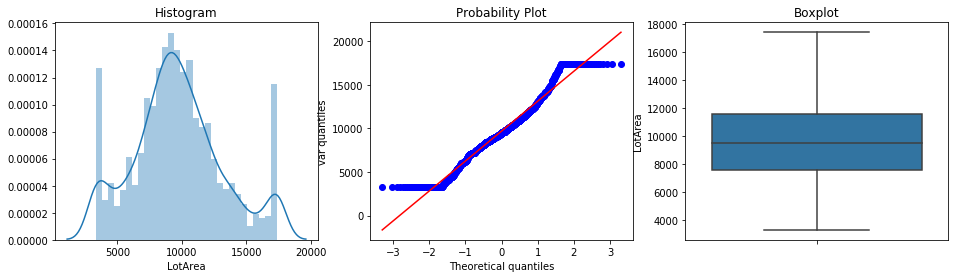

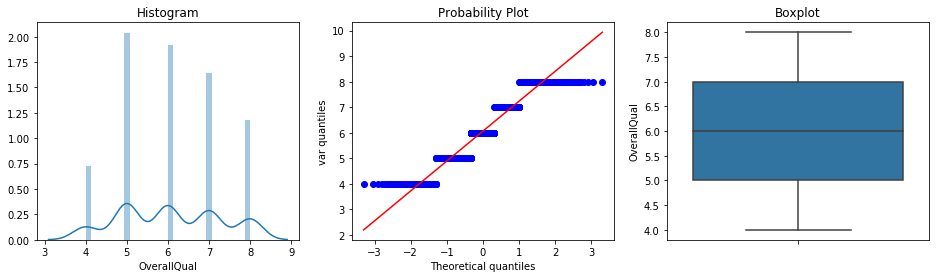

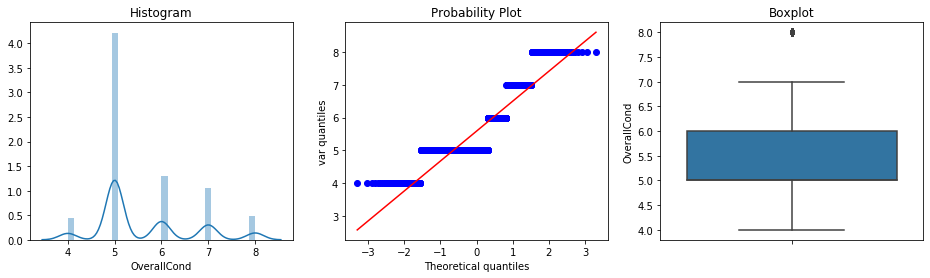

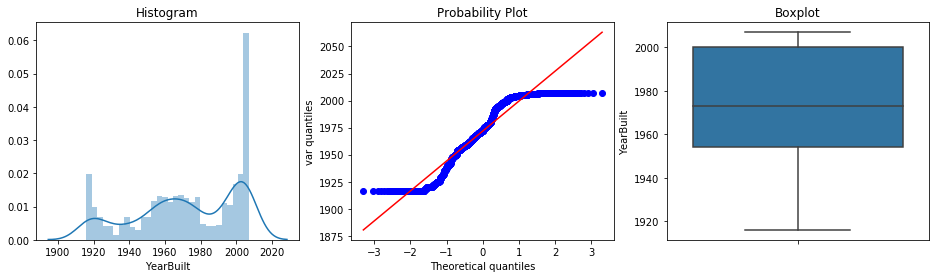

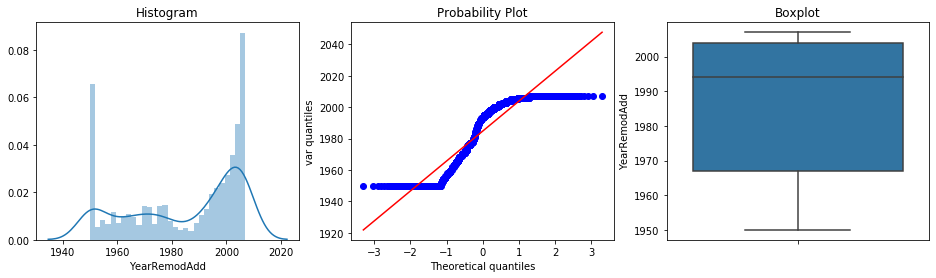

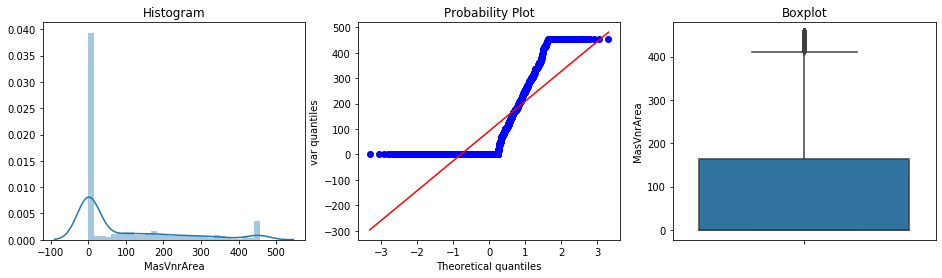

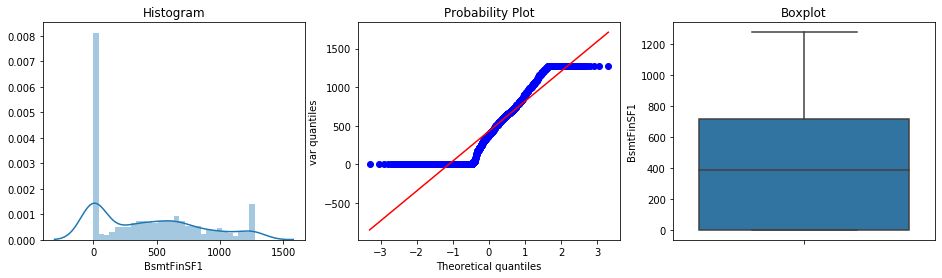

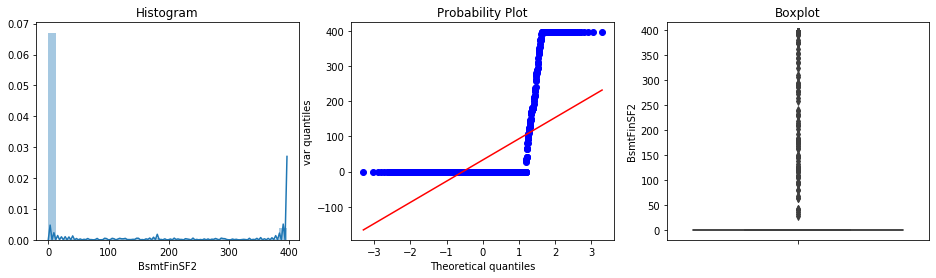

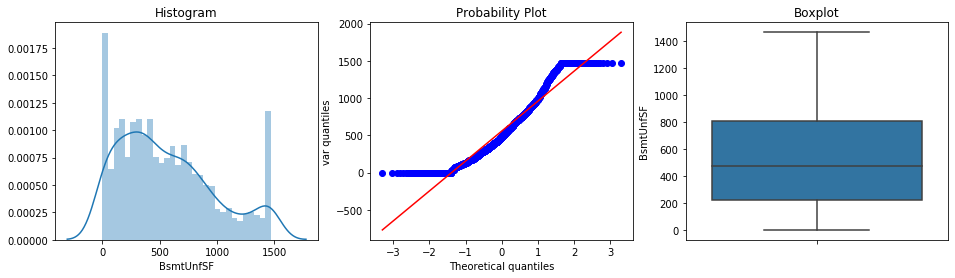

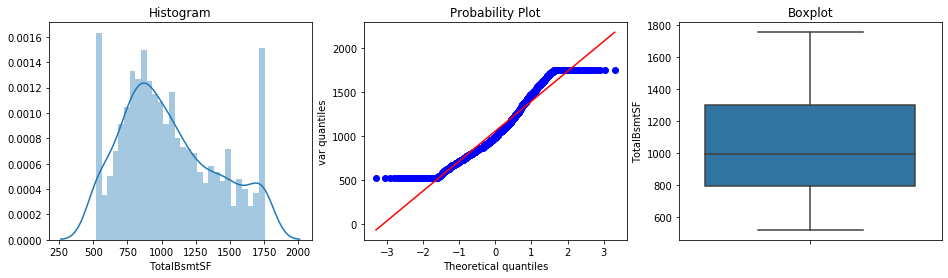

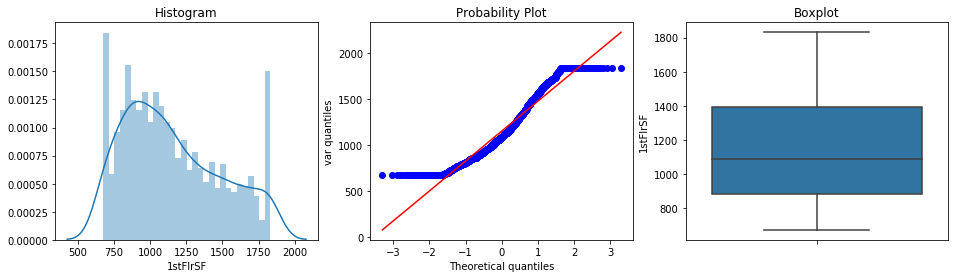

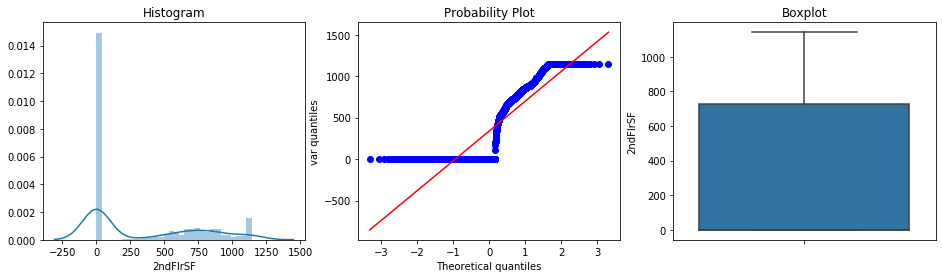

C:\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


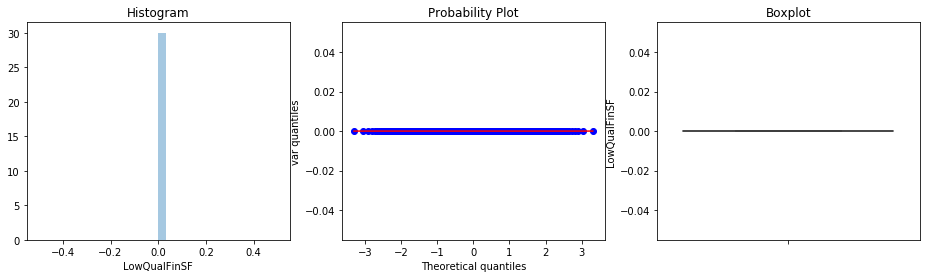

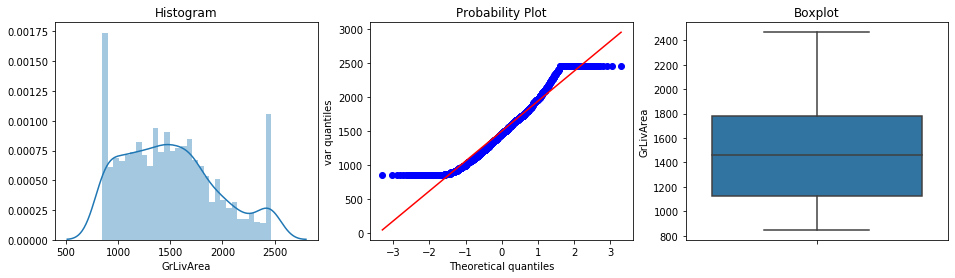

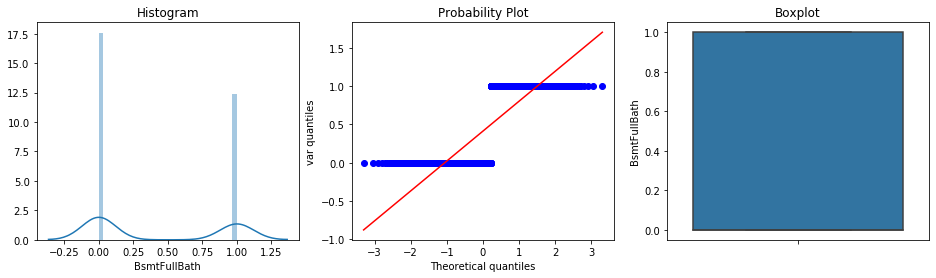

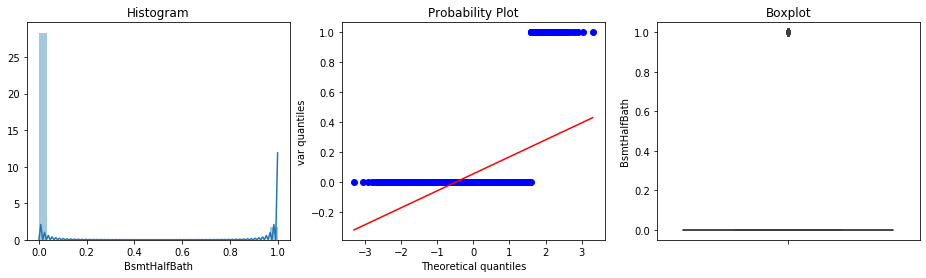

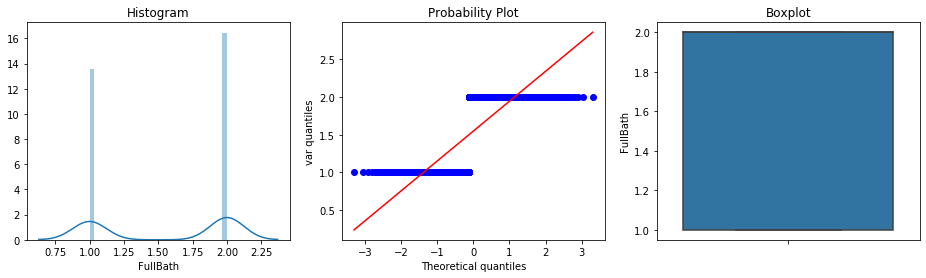

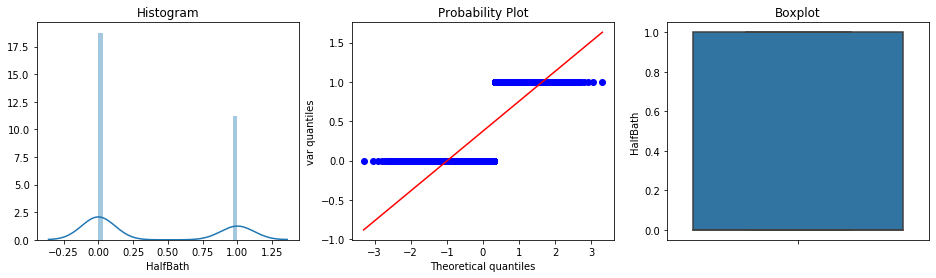

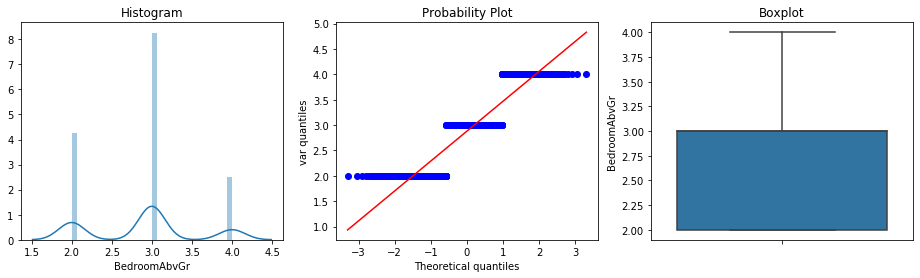

C:\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


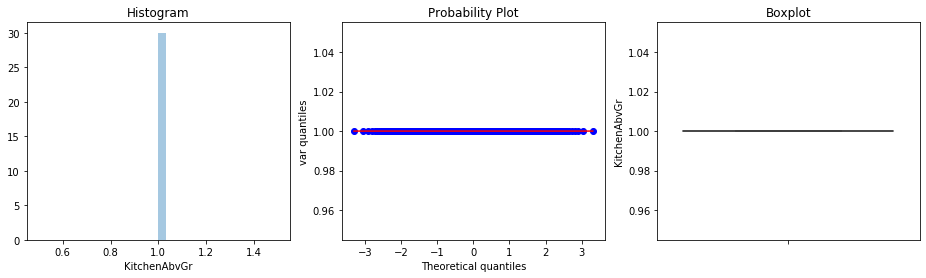

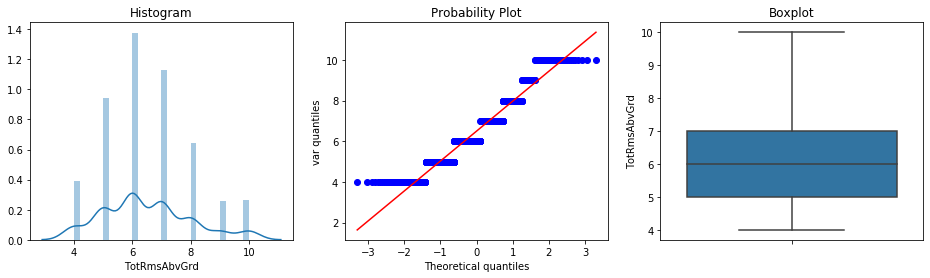

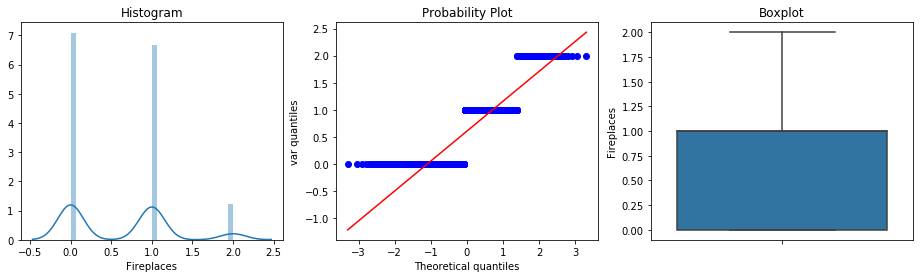

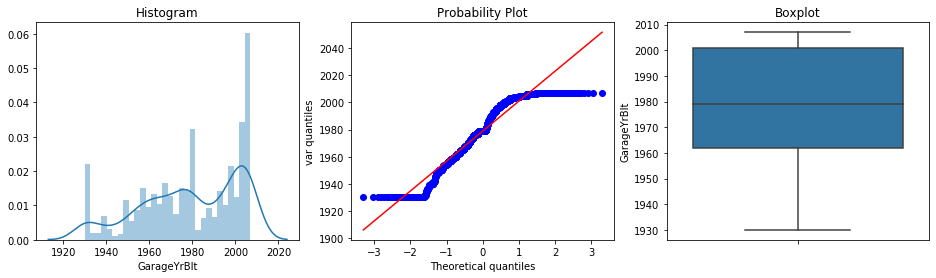

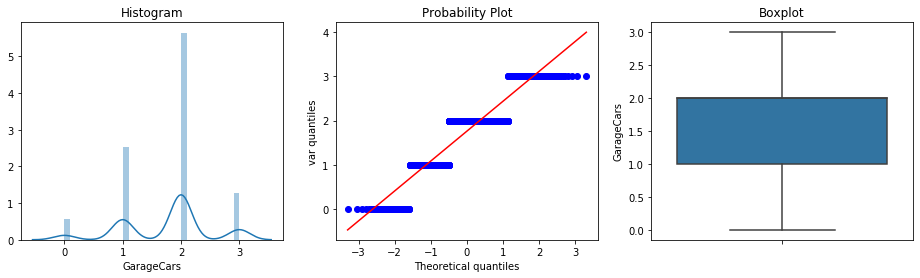

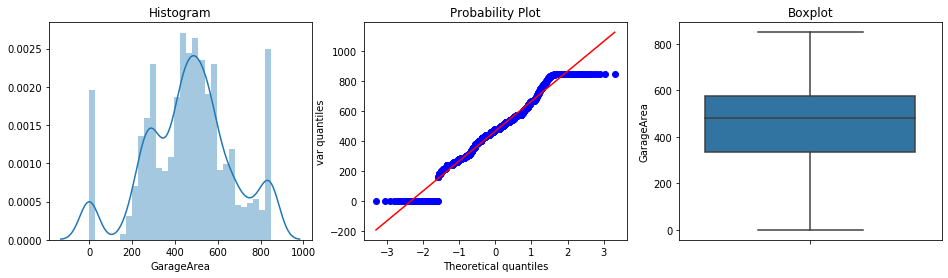

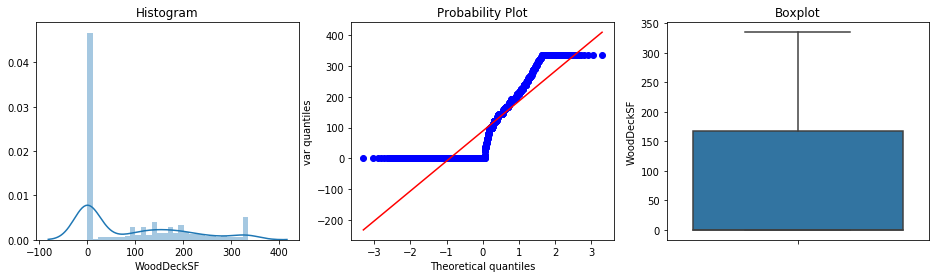

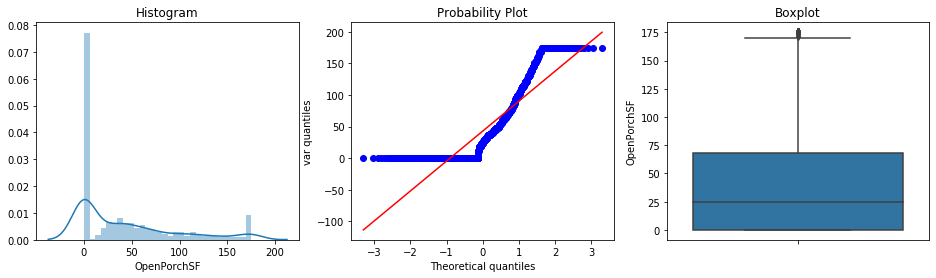

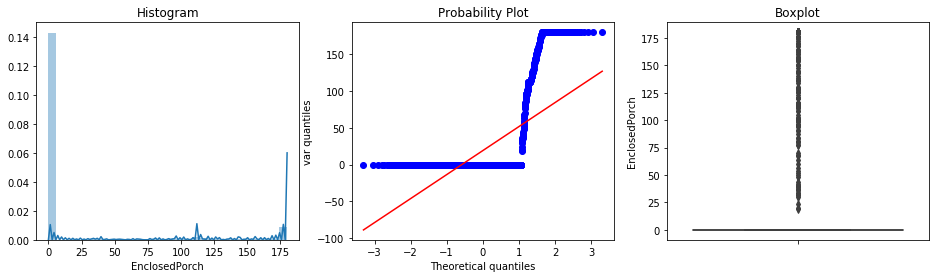

C:\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


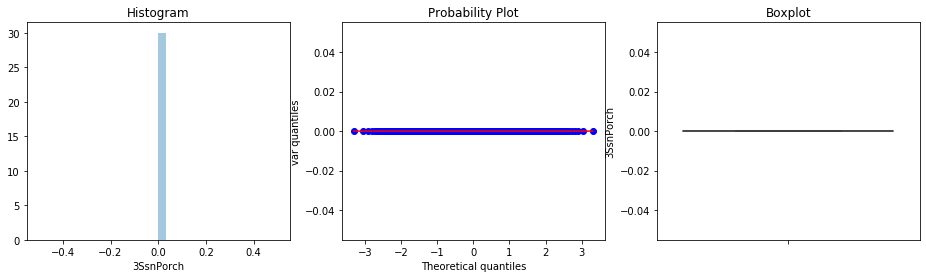

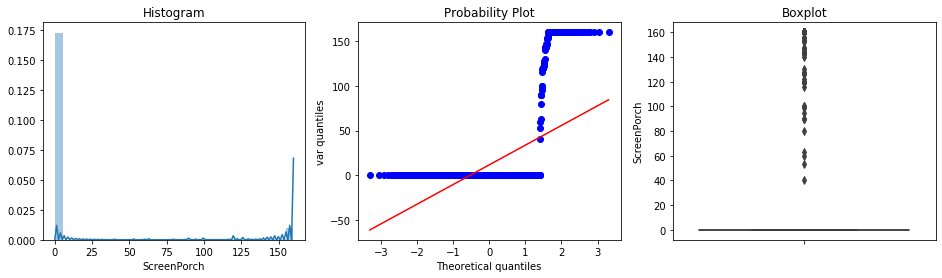

C:\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


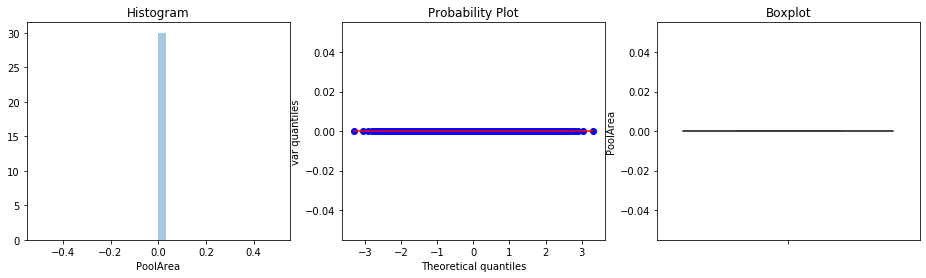

C:\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


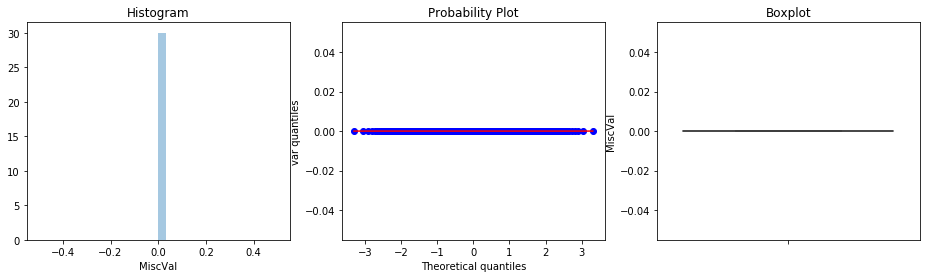

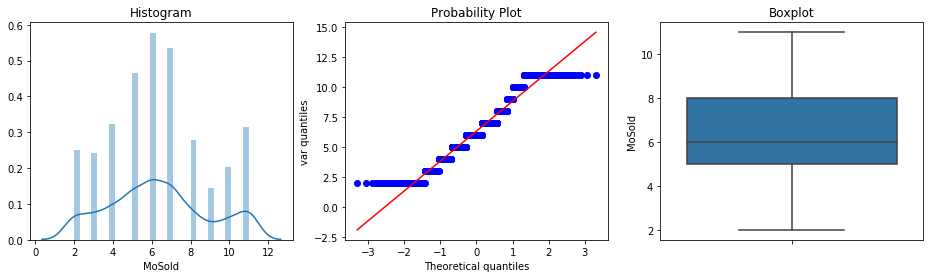

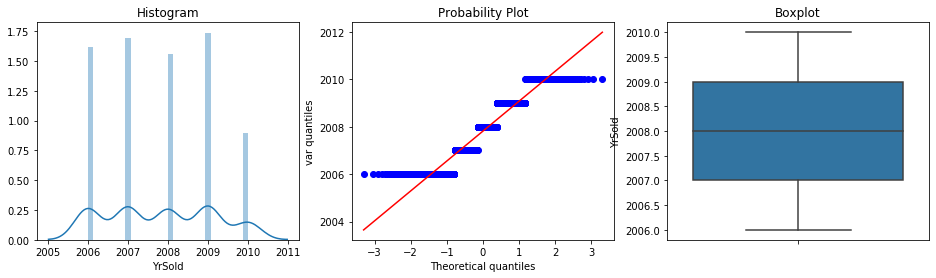

In [26]:
for var in quan:
    diagnostic_plots(df_train, var)

In [34]:
df_train['MSSubClass'] = np.where(df_train['MSSubClass'] > outliers['MSSubClass'][0], outliers['MSSubClass'][0],
                       np.where(df_train['MSSubClass'] < outliers['MSSubClass'][1], outliers['MSSubClass'][1], df_train['MSSubClass']))

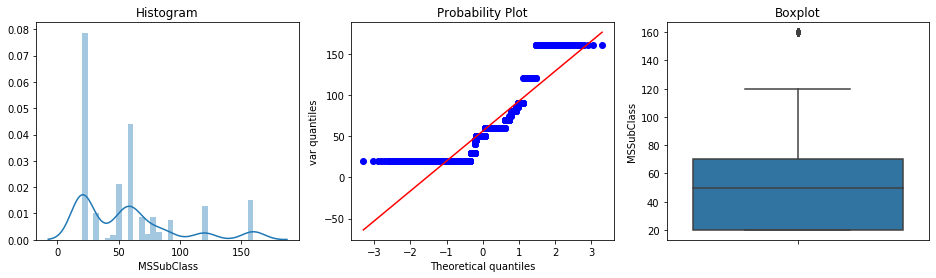

In [35]:
diagnostic_plots(df_train, 'MSSubClass')